In [1]:
from pprint import PrettyPrinter
pp = PrettyPrinter(compact=True, indent=4, depth=3)
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from tdigest import TDigest
from matplotlib.lines import Line2D

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.Decentralized_CP_NonIID  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
np.random.seed(0)

In [2]:
fst, snd = map(itemgetter, range(2))

In [3]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

# path_to_experiments = Path('new_experiments/')
path_to_experiments = Path('../experiments/')

In [4]:
reload(helpers)
dataset = 'cifar100'

experiment_names = ['central']
clients_class_map = helpers.get_client_map(dataset)

num_classes = sum(map(len, clients_class_map.values()))
# model = 'cnn'
model = 'small_resnet14'
experiments = {
    'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
}
partition = None

experiments = dict(filter(snd, experiments.items()))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times
findfont: Generic family 'sans-serif' not found because

0.04777436185437989
Graph with 20 nodes and 40 edges


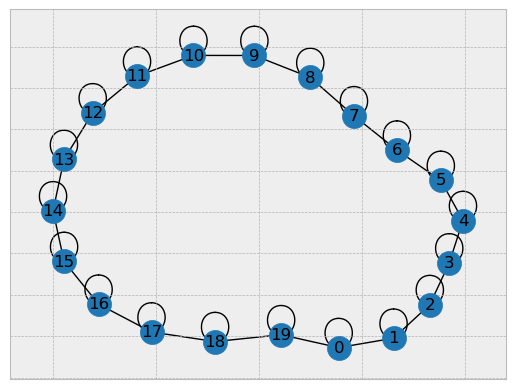

In [5]:
import networkx as net
import matplotlib.pyplot as plt

num_clients = len(clients_class_map)
topo = 'cycle'
G, W, P = helpers.graph_construct(topo, num_clients)

eigenvalues = np.sort(np.abs(np.linalg.eigvals(W)))
gamma = 1
rho = 1 - np.abs(eigenvalues[-2])
print(rho)

# Create a graph from the adjacency matrix P
G = net.from_numpy_array(P)
print(G)
# Plot the graph using networkx and matplotlib
net.draw_networkx(G)

## Run Split CP in a centralized setting

In [6]:
reload(cp)
reload(helpers)
reload(ts)

num_trials = 10

central_trials = {}
central_quantized_trials = {}
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, frac=0.1, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']
    
    # partition validation data into clients
    client_index_map = {
        k: sum(trial_experiments['central']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()
    }

    # conformal parameters
    # alphas = np.arange(0.05, 1, 0.05)
    alphas = np.arange(0.10, 1, 0.10)
    alphas = list(map(lambda x: np.round(x, 2), alphas))
    
    # allow_empty_sets = False # set to True for upper marginal bound
    allow_empty_sets = True
    
    method = 'lac' # score function: naive, lac, aps, raps

    # f = itemgetter('temp_val_scores', 'val_targets', 'temp_test_scores', 'test_targets')
    f = itemgetter('val_scores', 'val_targets', 'test_scores', 'test_targets')

    central_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['central']), method=method, 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=False
    )
    central_trials[i] = central_metrics

    print(f'finished trial={i}')
    

finished trial=0
finished trial=1
finished trial=2
finished trial=3
finished trial=4
finished trial=5
finished trial=6
finished trial=7
finished trial=8
finished trial=9


In [7]:
reload(helpers)

central_results = helpers.combine_trials(central_trials)

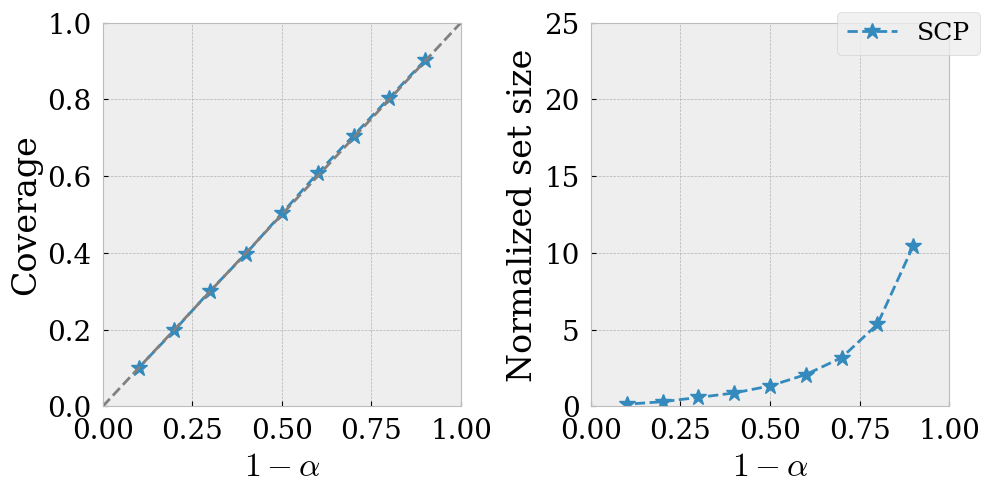

In [8]:
alphas = np.arange(0.10, 1, 0.10)
alphas = list(map(lambda x: np.round(x, 2), alphas))

# plotting settings
fontsize=24
style = '--'
markersize=12

exp_1 = central_results['mean']
exp_1_label = 'SCP'

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].plot(*zip(*exp_1['coverage'].items()), style, marker='*', label=exp_1_label, markersize=markersize)
ax[1].plot(*zip(*exp_1['size'].items()), style, marker='*',  markersize=markersize)
    
ax[0].plot([0, 1], [0, 1], '--', color='gray')

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 25)
ax[0].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[1].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)
ax[1].set_ylabel('Normalized set size', fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
fig.legend(ncol=4, fontsize=fontsize - 6, 
          # title='Federated model', title_fontsize=fontsize - 6, 
          # bbox_to_anchor=(0.15, 0, 1, 1.20), 
           fancybox = True, #shadow = True,
           # mode="expand",
 )

plt.tight_layout()
plt.show()

### Plot Coverage and Set Size of Different Topologies with Fixed Gossip Iteration over Alpha

In [9]:
reload(cp)
reload(helpers)
reload(ts)

num_clients = len(clients_class_map)

num_trials = 10
gossip = 150
quantization_M = 1000
    
# topo_list = ['torus', 'star', 'cycle', 'CG', 'chain', 'star-ER', 'chain-ER']
topo_list = ['torus', 'star', 'cycle', 'CG', 'chain']
# topo_list = ['cycle']

topo_results = {}
decentralized_trials = [{} for topo in topo_list]
    
# conformal parameters
alphas = list(map(lambda x: np.round(x, 2), alphas))

# allow_empty_sets = False # set to True for upper marginal bound
allow_empty_sets = True

method = 'lac' # score function: naive, lac, aps, raps
f = itemgetter('val_scores', 'val_targets', 'test_scores', 'test_targets')


In [10]:
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, frac=0.1)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']
    
    # partition validation data into clients
    client_index_map = {
        k: sum(trial_experiments['central']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()
    }
    
    for topo_ind, topo in enumerate(topo_list):
        G, W, P = helpers.graph_construct(topo, num_clients)
        
        eigenvalues = np.sort(np.abs(np.linalg.eigvals(W)))
        gamma = 1
        rho = 1 - np.abs(eigenvalues[-2])

        decentral_metrics = cp.get_decentralized_coverage_size_over_alphas(
            *f(trial_experiments['central']), method=method, 
            allow_empty_sets=allow_empty_sets, alphas=alphas, 
            decentral=True, gossip = gossip, client_index_map=client_index_map,
            quantization_M=quantization_M, W=W,
        )
        decentralized_trials[topo_ind][i] = decentral_metrics
        
        print(f'Topo={topo}, Finished trial={i}')
    
for topo_ind, topo in enumerate(topo_list):
    topo_results[topo] = helpers.combine_trials(decentralized_trials[topo_ind]) 

Topo=torus, Finished trial=0
Topo=star, Finished trial=0
Topo=cycle, Finished trial=0
Topo=CG, Finished trial=0
Topo=chain, Finished trial=0
Topo=torus, Finished trial=1
Topo=star, Finished trial=1
Topo=cycle, Finished trial=1
Topo=CG, Finished trial=1
Topo=chain, Finished trial=1
Topo=torus, Finished trial=2
Topo=star, Finished trial=2
Topo=cycle, Finished trial=2
Topo=CG, Finished trial=2
Topo=chain, Finished trial=2
Topo=torus, Finished trial=3
Topo=star, Finished trial=3
Topo=cycle, Finished trial=3
Topo=CG, Finished trial=3
Topo=chain, Finished trial=3
Topo=torus, Finished trial=4
Topo=star, Finished trial=4
Topo=cycle, Finished trial=4
Topo=CG, Finished trial=4
Topo=chain, Finished trial=4
Topo=torus, Finished trial=5
Topo=star, Finished trial=5
Topo=cycle, Finished trial=5
Topo=CG, Finished trial=5
Topo=chain, Finished trial=5
Topo=torus, Finished trial=6
Topo=star, Finished trial=6
Topo=cycle, Finished trial=6
Topo=CG, Finished trial=6
Topo=chain, Finished trial=6
Topo=torus, F

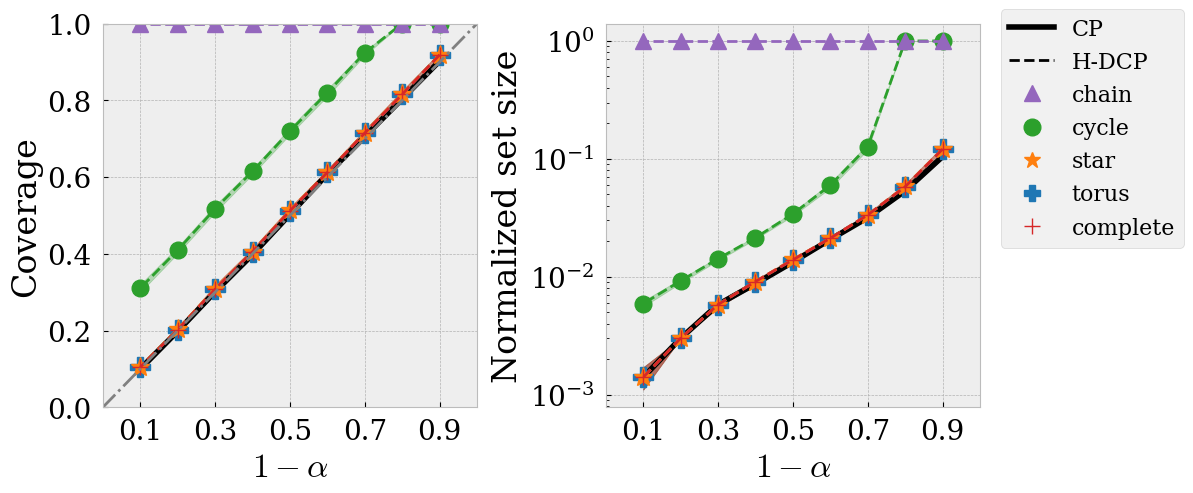

In [11]:
alphas = np.arange(0.10, 1, 0.10)
alphas = list(map(lambda x: np.round(x, 2), alphas))

# plotting settings
fontsize=24
style = '--'
markersize=12
markerlist = {
    'chain': '^',
    'cycle': 'o', 
    'star': '*',
    'torus': 'P',
    'CG': '+', 
    # 'ER': '1',
    # 'chain-ER': '2',
    # 'star-ER': '3',
}
colors = plt.cm.tab10.colors
topo_colors = {topo: colors[i % len(colors)] for i, topo in enumerate(topo_list)}

exp_1 = central_results['mean']
exp_1_label = 'CP w/o Quantization'

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].plot(*zip(*exp_1['coverage'].items()), 'k-', linewidth=4, label=exp_1_label, markersize=markersize)
ax[1].plot(exp_1['size'].keys(), np.array(list(exp_1['size'].values()))/100, 'k-', linewidth=4,  markersize=markersize)

mean = np.array(list(exp_1['coverage'].values()))
std = np.array(list(central_results['std']['coverage'].values()))
lower = mean - 1.96 * std / np.sqrt(10)
upper = mean + 1.96 * std / np.sqrt(10)
ax[0].fill_between(exp_1['coverage'].keys(), lower, upper, color='black', alpha=0.3)

mean = np.array(list(exp_1['size'].values()))
std = np.array(list(central_results['std']['size'].values()))
lower = mean - 1.96 * std / np.sqrt(10)
upper = mean + 1.96 * std / np.sqrt(10)
ax[1].fill_between(exp_1['size'].keys(), lower/100, upper/100, color='black', alpha=0.3)

for topo in topo_list:
    decentral_results = topo_results[topo]
    exp_2 = decentral_results['mean']
    exp_2_label = 'Decentralized'
    if topo == 'torus' or topo == 'star':
        ax[0].plot(*zip(*exp_2['coverage'].items()), style, color=topo_colors[topo], marker=markerlist[topo], label=topo, markersize=markersize + 2)
        ax[1].plot(exp_2['size'].keys(), np.array(list(exp_2['size'].values()))/100, style, color=topo_colors[topo], marker=markerlist[topo],  markersize=markersize + 2)
    else:
        ax[0].plot(*zip(*exp_2['coverage'].items()), style, color=topo_colors[topo], marker=markerlist[topo], label=topo, markersize=markersize)
        ax[1].plot(exp_2['size'].keys(), np.array(list(exp_2['size'].values()))/100, style, color=topo_colors[topo], marker=markerlist[topo],  markersize=markersize)
    
    mean = np.array(list(exp_2['coverage'].values()))
    std = np.array(list(decentral_results['std']['coverage'].values()))
    lower = mean - 1.96 * std / np.sqrt(10)
    upper = mean + 1.96 * std / np.sqrt(10)
    ax[0].fill_between(exp_2['coverage'].keys(), lower, upper, color=topo_colors[topo], alpha=0.3)
    
    mean = np.array(list(exp_2['size'].values()))
    std = np.array(list(decentral_results['std']['size'].values()))
    lower = mean - 1.96 * std / np.sqrt(10)
    upper = mean + 1.96 * std / np.sqrt(10)
    ax[1].fill_between(exp_2['size'].keys(), lower/100, upper/100, color=topo_colors[topo], alpha=0.3)
    
    
legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', linewidth=4, label='CP'),
    Line2D([0], [0], color='k', linestyle='--', label='H-DCP'),
]

for topo, marker in markerlist.items():
    plot_label = 'complete' if topo == 'CG' else topo
    legend_elements.append(
        Line2D([0], [0], linestyle='', marker=marker, color=topo_colors[topo], label=plot_label, markersize=markersize)
    )
    
ax[0].plot([0, 1], [0, 1], '-.', color='gray')

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].set_yscale('log')
ax[0].set_ylim(0, 1)
ax[0].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[1].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)
ax[1].set_ylabel('Normalized set size', fontsize=fontsize)
ax[0].set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax[1].set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
fig.legend(ncol=1, handles=legend_elements, fontsize=fontsize - 8, 
          bbox_to_anchor=(0, 0, 1.2, 1), 
           fancybox = True, #shadow = True,
)
plt.tight_layout()
plt.savefig(fig_dir / f'DCP_noniid_topo_alpha_gossip_{str(gossip)}_{dataset}_{method}.pdf', bbox_inches='tight')
plt.show()

### Plot Coverage and Set Size of Different Topologies with Fixed Alpha over Gossip Iteration

In [12]:
reload(cp)
reload(helpers)
reload(ts)

num_clients = len(clients_class_map)

num_trials = 10
alpha = 0.1
gossips = np.logspace(0, 4, 40)
# gossips = [200]
quantization_M = 1000
    
# topo_list = ['torus', 'star', 'cycle', 'CG', 'chain', 'star-ER', 'chain-ER']
topo_list = ['torus', 'star', 'cycle', 'CG', 'chain']
# topo_list = ['cycle']

topo_gossip_results = {}
decentralized_trials = [{} for topo in topo_list]

# allow_empty_sets = False # set to True for upper marginal bound
allow_empty_sets = True

method = 'lac' # score function: naive, lac, aps, raps
f = itemgetter('val_scores', 'val_targets', 'test_scores', 'test_targets')

In [13]:
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, frac=0.1)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']

    # partition validation data into clients
    client_index_map = {
        k: sum(trial_experiments['central']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()
    }

    for topo_ind, topo in enumerate(topo_list):
        G, W, P = helpers.graph_construct(topo, num_clients)
        
        eigenvalues = np.sort(np.abs(np.linalg.eigvals(W)))
        gamma = 1
        rho = 1 - np.abs(eigenvalues[-2])

        decentral_metrics = cp.get_decentralized_coverage_size_over_gossip(
            *f(trial_experiments['central']), method=method, 
            allow_empty_sets=allow_empty_sets, alpha=alpha, 
            decentral=True, gossips = gossips, client_index_map=client_index_map,
            quantization_M=quantization_M, W=W,
        )
        decentralized_trials[topo_ind][i] = decentral_metrics
        
        print(f'Topo={topo}, Finished trial={i}')
    
for topo_ind, topo in enumerate(topo_list):
    topo_gossip_results[topo] = helpers.combine_trials(decentralized_trials[topo_ind]) 

Topo=torus, Finished trial=0
Topo=star, Finished trial=0
Topo=cycle, Finished trial=0
Topo=CG, Finished trial=0
Topo=chain, Finished trial=0
Topo=torus, Finished trial=1
Topo=star, Finished trial=1
Topo=cycle, Finished trial=1
Topo=CG, Finished trial=1
Topo=chain, Finished trial=1
Topo=torus, Finished trial=2
Topo=star, Finished trial=2
Topo=cycle, Finished trial=2
Topo=CG, Finished trial=2
Topo=chain, Finished trial=2
Topo=torus, Finished trial=3
Topo=star, Finished trial=3
Topo=cycle, Finished trial=3
Topo=CG, Finished trial=3
Topo=chain, Finished trial=3
Topo=torus, Finished trial=4
Topo=star, Finished trial=4
Topo=cycle, Finished trial=4
Topo=CG, Finished trial=4
Topo=chain, Finished trial=4
Topo=torus, Finished trial=5
Topo=star, Finished trial=5
Topo=cycle, Finished trial=5
Topo=CG, Finished trial=5
Topo=chain, Finished trial=5
Topo=torus, Finished trial=6
Topo=star, Finished trial=6
Topo=cycle, Finished trial=6
Topo=CG, Finished trial=6
Topo=chain, Finished trial=6
Topo=torus, F

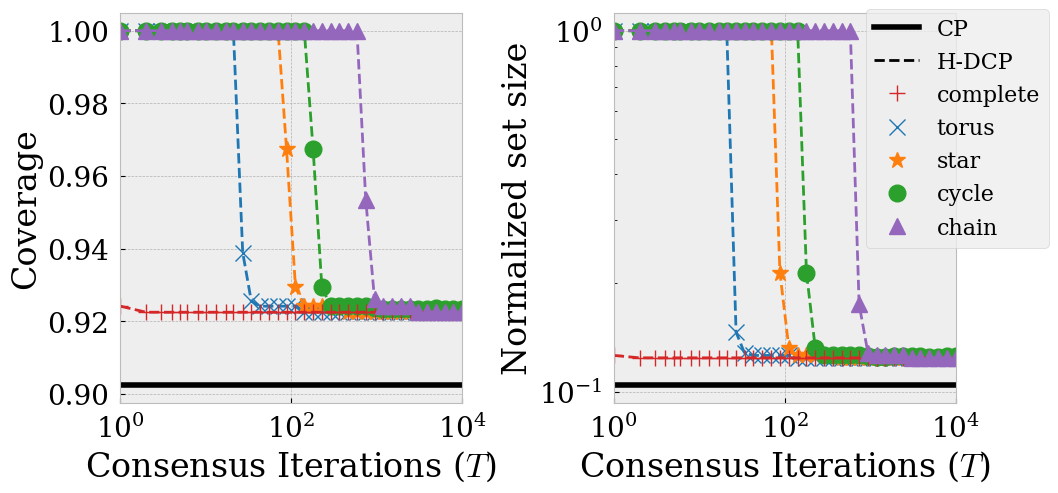

In [14]:
# plotting settings
fontsize=24
style = '--'
markersize=12
markerlist = {
    'CG': '+', 
    'torus': 'x',
    'star': '*',
    'cycle': 'o', 
    'chain': '^',
    # 'ER': '1',
    # 'chain-ER': '2',
    # 'star-ER': '3',
}

colors = plt.cm.tab10.colors
topo_colors = {topo: colors[i % len(colors)] for i, topo in enumerate(topo_list)}

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

exp = central_results['mean']
exp_label = 'CP'
ax[0].plot(gossips, np.ones(shape=(len(gossips), 1)) * list(exp['coverage'].values())[0], 'k-', linewidth=4)
ax[1].plot(gossips, np.ones(shape=(len(gossips), 1)) * np.array(list(exp['size'].values()))[0]/100, 'k-', linewidth=4)

for topo in topo_list:
    decentral_results = topo_gossip_results[topo]
    exp_2 = decentral_results['mean']
    exp_2_label = 'Decentralized'
    ax[0].plot(*zip(*exp_2['coverage'].items()), style, color=topo_colors[topo], marker=markerlist[topo], label=topo, markersize=markersize)
    ax[1].plot(exp_2['size'].keys(), np.array(list(exp_2['size'].values()))/100, style, color=topo_colors[topo], marker=markerlist[topo],  markersize=markersize)
    
legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', linewidth=4, label='CP'),
    Line2D([0], [0], color='k', linestyle='--', label='H-DCP'),
]

for topo, marker in markerlist.items():
    plot_label = 'complete' if topo == 'CG' else topo
    legend_elements.append(
        Line2D([0], [0], linestyle='', marker=marker, color=topo_colors[topo], label=plot_label, markersize=markersize)
    )

ax[0].set_xlim(gossips[0], gossips[-1])
ax[1].set_xlim(gossips[0], gossips[-1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel(r'Consensus Iterations ($T$)', fontsize=fontsize)
ax[1].set_xlabel(r'Consensus Iterations ($T$)', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)
ax[1].set_ylabel('Normalized set size', fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
fig.legend(ncol=1, handles=legend_elements, fontsize=fontsize - 8, 
          bbox_to_anchor=(0, 0, 1.065, 1), 
           fancybox = True, #shadow = True,
)

plt.tight_layout()
plt.savefig(fig_dir / f'DCP_noniid_topo_gossip_alpha_{str(alpha)}_{dataset}_{method}.pdf', bbox_inches='tight')
plt.show()